In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

from datetime import datetime
from datetime import timedelta

In [2]:
# Import the datasets to be used for this project
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
weather = pd.read_csv("./data/weather.csv")
spray = pd.read_csv("./data/spray.csv")

# 1. Data Cleaning & EDA

## 1.1 Train & test dataset

### Train

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [4]:
train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


- 12 features
- Approx. 10,000 samples

In [5]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,29/5/2007,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,29/5/2007,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,29/5/2007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,29/5/2007,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,29/5/2007,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


### Test

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [7]:
test.describe()

,Id,Block,Latitude,Longitude,AddressAccuracy
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000
mean,58147.000000,41.131100,41.849389,-87.693658,7.954357
std,33571.041765,24.864726,0.106593,0.080699,1.252733
min,1.000000,10.000000,41.644612,-87.930995,3.000000
25%,29074.000000,18.000000,41.753411,-87.750938,8.000000
50%,58147.000000,39.000000,41.862292,-87.694991,8.000000
75%,87220.000000,61.000000,41.951866,-87.648860,9.000000
max,116293.000000,98.000000,42.017430,-87.531635,9.000000


- 11 features (no NumMosquitos feature)
- Approx. 110k samples

### Data Cleaning

#### Dropping features

In [8]:
# Drop NumMosquitos feature as it is not present in test.csv
train.drop(columns='NumMosquitos', inplace=True)

In [9]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent'],
      dtype='object')

In [10]:
# Address, Block, Street, AddressNumberAndStreet, AddressAccuracy can all be dropped
# These features are string data type, and give location based info.
# Location info. can be obtained through Latitude and Longitude
train.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)

# Drop whatever was dropped for train.csv
test.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)

In [11]:
# 'Trap' is just the code of the trap, which is also the location
# Since there is numerical data for the location, trap can be dropped
train.drop(columns=['Trap'], inplace=True)
test.drop(columns=['Trap'], inplace=True)

#### Changing data type

In [12]:
# Date feature is a string
# Change to date-time type
train['Date'] = pd.to_datetime(train['Date'])

In [13]:
train.head()

,Date,Species,Latitude,Longitude,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0


### Splitting train.csv to training & testing set

In [14]:
# Split train.csv to training_set and testing_set
X = train[['Date', 'Species', 'Latitude', 'Longitude']]
y = train['WnvPresent']
X_training, X_testing, y_training, y_testing = train_test_split(X, y, stratify=y)

In [15]:
# Check out dimension for X_training
X_training.shape

(7879, 4)

### Preliminary EDA on training set

In [16]:
# Merge X_training and y_training for EDA
training = X_training.join(y_training)

- **Baseline**

In [17]:
# Get baseline accuracy score for predicting absence of virus
training['WnvPresent'].value_counts(normalize=True)

0    0.947582
1    0.052418
Name: WnvPresent, dtype: float64

- Baseline accuracy score for predicting absence of WNV is 94.76%
- Shows how rare the virus actually is

- **WNV cases across time periods**

Text(0.5, 1.0, 'No. of WNV mosquitos in a given year')

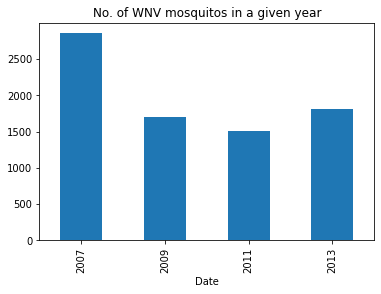

In [18]:
# See the number of WNV cases across year
ax = training.groupby(train['Date'].dt.year).count()['WnvPresent'].plot(kind='bar')
ax.set_title('No. of WNV mosquitos in a given year')

Inference:
- 2007 was the year with highest number of WNV carriers
- 2011 was the year with least

Text(0.5, 1.0, 'No. of WNV mosquitos in a given month, averaged over the 4 years')

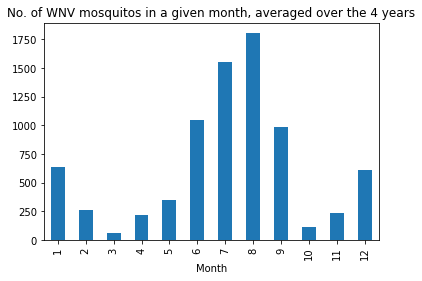

In [19]:
# See the number of WNV cases across months
ax = training.groupby(train['Date'].dt.month).count()['WnvPresent'].plot(kind='bar')
ax.set_xlabel('Month')
ax.set_title('No. of WNV mosquitos in a given month, averaged over the 4 years')

Inference:
- Across the time period, July and August had the highest numbers of WNV carriers.
- July and August are the summer months for Chicago (https://www.tripsavvy.com/best-time-to-visit-chicago-4175898)

- **Species of mosquito and relation to WNV**

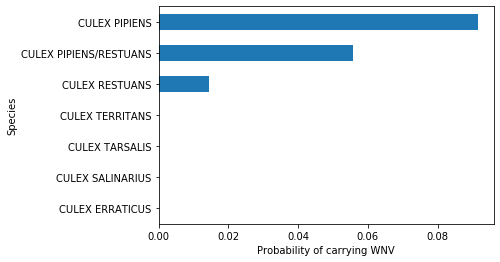

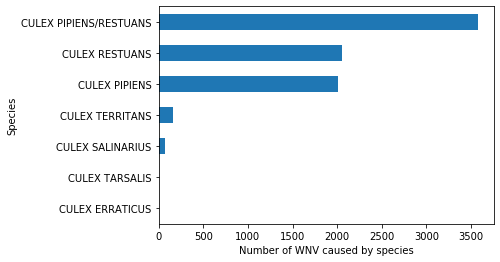

In [20]:
# Get a sense of the various species of mosquitos
# Some species could be carriers of the virus
ax = training.groupby('Species').mean()['WnvPresent'].sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Probability of carrying WNV')
plt.show()
ax = training.groupby('Species').count()['WnvPresent'].sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Number of WNV caused by species')
plt.show()

Inference:
- Culex Pipiens/Restuans species have highest probability of carrying WNV.

## 1.2 Weather dataset

In [21]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [22]:
weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


In [23]:
pd.set_option('max_columns', 500)
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,1/5/2007,83,50,67,14,51,56,0,2,448,1849,,0,M,0,0,29.1,29.82,1.7,27,9.2
1,2,1/5/2007,84,52,68,M,51,57,0,3,-,-,,M,M,M,0,29.18,29.82,2.7,25,9.6
2,1,2/5/2007,59,42,51,-3,42,47,14,0,447,1850,BR,0,M,0,0,29.38,30.09,13.0,4,13.4
3,2,2/5/2007,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0,29.44,30.08,13.3,2,13.4
4,1,3/5/2007,66,46,56,2,40,48,9,0,446,1851,,0,M,0,0,29.39,30.12,11.7,7,11.9


### Data Cleaning

In [24]:
# Change Date to date-time data type
weather['Date'] = pd.to_datetime(weather['Date'])

In [25]:
# Drop Tmax and Tmin
# There is no info. on how long the temperature was at max/min, and there is a Tavg already
weather.drop(columns=['Tmax', 'Tmin'], inplace=True)

In [26]:
# From data dictionary, 'depart' is departure from normal
# It does not give much information, and a lot of values are missing
# Therefore, this column will be dropped
print('Amount of rows with missing data in Depart column:', weather[weather['Depart'] == 'M'].shape[0])
weather.drop(columns='Depart', inplace=True)

Amount of rows with missing data in Depart column: 1472


In [27]:
# DewPoint and WetBulb features are a measure of humidity, therefore should keep
# Heat, Cool is info. on the hotness/coolness on that day, which is given by the Temperature measurements already
# Sunrise, Sunset, SnowFall is also kind of related to the temperature 
weather.drop(columns=['Heat', 'Cool', 'Sunrise', 'Sunset', 'SnowFall'], inplace=True)

In [28]:
# Drop CodeSum column
# From the data dictionary, it is info. on weather phenomena
# However, the information is hard to interpret and the number of possible combinations is really high
# Also, there is a very unbalanced distribution, and therefore it is decided that this column will be dropped
print(weather['CodeSum'].value_counts())
weather.drop(columns='CodeSum', inplace=True)

                         1609
RA                        296
RA BR                     238
BR                        110
TSRA RA BR                 92
BR HZ                      81
RA DZ BR                   65
TSRA RA                    43
HZ                         39
RA BR HZ                   38
TSRA                       34
RA DZ                      22
TSRA BR                    21
TS TSRA RA BR              19
RA HZ                      16
TS RA                      13
TSRA RA BR HZ              12
DZ BR                      10
TS TSRA BR                 10
TS                         10
DZ BR HZ                    9
TSRA BR HZ                  8
DZ                          8
TS RA BR                    8
TS TSRA                     7
TS TSRA BR HZ               7
TS TSRA RA                  7
RA DZ BR HZ                 7
RA SN                       4
TSRA RA BR VCTS             4
                         ... 
RA SN BR                    1
RA VCTS                     1
TSRA RA FG

In [29]:
# As high number of missing values in Depth and Water1 columns, drop these columns
print('Number of missing values in Depth column:', weather[weather['Depth'] == 'M'].shape[0])
print('Number of missing values in Water1 column:', weather[weather['Water1'] == 'M'].shape[0])
weather.drop(columns=['Depth', 'Water1'], inplace=True)

Number of missing values in Depth column: 1472
Number of missing values in Water1 column: 2944


In [30]:
# 'PrecipTotal' is the amount of rain in a 24 hr period
# The column dtype is a string, as some entries is 'T' meaning trace amt (according to the data dictionary)
weather['PrecipTotal'].values

array(['0', '0', '0', ..., '  T', '0.03', '0.04'], dtype=object)

In [31]:
# 'T' has whitespace in front, must use .strip() to clean it
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.strip())

# Convert 'T' entries to 0, and convert dtype to float
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('T', '0.001'))
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('M', '0'))
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [32]:
# Tavg (the average temperature on that day) has missing values
weather[weather['Tavg'] == 'M'].shape

(11, 11)

In [33]:
# Since there are only 11 missing values for Tavg out of 2944 entries, it is safe to drop the missing values
weather = weather[weather['Tavg'] != 'M']

# Convert Tavg dtype to float
weather['Tavg'] = weather['Tavg'].astype(float)

In [34]:
# Drop StnPressure, SeaLevel, ResultSpeed, ResultDir and AvgSpeed
# These are generic conditions which do not really relate to mosquito population
weather.drop(columns=['StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'], inplace=True)

In [35]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tavg                  float64
DewPoint                int64
WetBulb                object
PrecipTotal           float64
dtype: object

- All columns are now numerical type

In [36]:
weather.head()

,Station,Date,Tavg,DewPoint,WetBulb,PrecipTotal
0,1,2007-01-05,67.0,51,56,0.0
1,2,2007-01-05,68.0,51,57,0.0
2,1,2007-02-05,51.0,42,47,0.0
3,2,2007-02-05,52.0,42,47,0.0
4,1,2007-03-05,56.0,40,48,0.0


- As the weather info is taken across 2 different stations each day, calc. the average across the 2.

In [37]:
weather = weather.groupby('Date').mean().reset_index().drop(columns='Station')

In [38]:
weather.head()

,Date,Tavg,DewPoint,PrecipTotal
0,2007-01-05,67.5,51.0,0.0
1,2007-01-06,75.5,63.0,0.2
2,2007-01-07,67.0,51.5,0.0
3,2007-01-08,80.5,62.5,0.0
4,2007-01-09,69.5,55.5,0.0


### Preliminary EDA for Weather data

In [39]:
weather.groupby(weather['Date'].dt.year).mean()

,Tavg,DewPoint,PrecipTotal
Date,,,
2007,69.160326,54.233696,0.108921
2008,66.057065,52.728261,0.153883
2009,64.364130,51.904891,0.129918
2010,68.687500,54.785326,0.153106
2011,67.005435,54.396739,0.147660
2012,69.070652,52.478261,0.090698
2013,66.880435,53.994565,0.109046
2014,66.562500,53.127717,0.161193


In [40]:
def plot_weather_trend_year(col_lst = weather.columns[1:]):
    for col in col_lst:
        ax = weather.groupby(weather['Date'].dt.year).mean()[col].sort_index().plot(kind='bar')
        ax.set_ylabel(f'{col}')
        ax.set_xlabel('Year')
        plt.show()

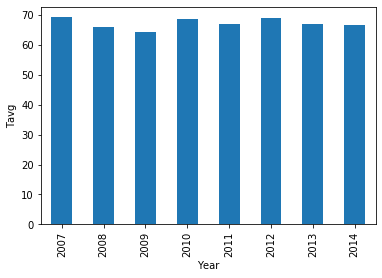

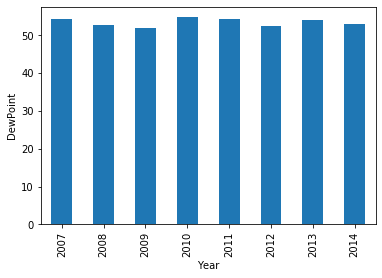

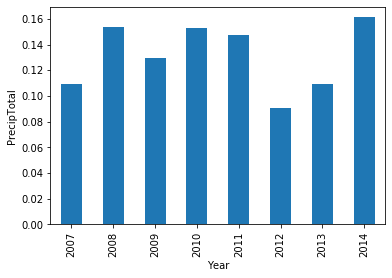

In [41]:
plot_weather_trend_year()

- 2007 was one of the hotter and more humid years
- This reflects the fact that 2007 was the year with the highest no. of mosquitos carrying WNV found.

In [42]:
def plot_weather_trend_month(col_lst = weather.columns[1:]):
    for col in col_lst:
        ax = weather.groupby(weather['Date'].dt.month).mean()[col].plot(kind='bar')
        ax.set_ylabel(f'{col}')
        ax.set_xlabel('Month')
        plt.show()

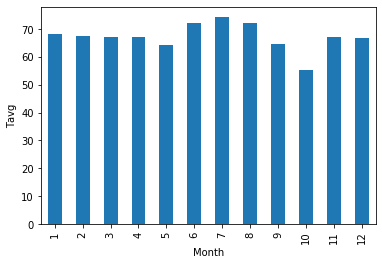

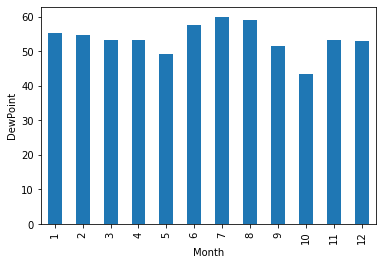

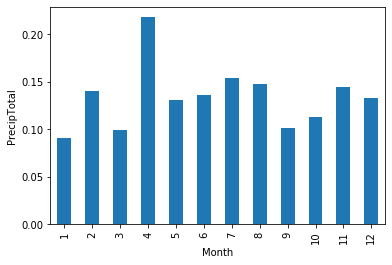

In [43]:
plot_weather_trend_month()

- July and August are 2 of the hottest months, and also the more humid months
- April had on average the highest precipitation amount, but surprisingly is not as humid as July or August

## 1.3 Spray dataset

In [44]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [45]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [46]:
# The 'Time' column can be dropped as it is too much granularity
# The other datasets do not have a 'Time' column and ultimately it is too much information
spray.drop(columns='Time', inplace=True)

In [47]:
# Convert 'Date' column to date-time
spray['Date'] = pd.to_datetime(spray['Date'])

In [48]:
# See the average number of locations sprayed in a given month across the 2011 and 2013
spray.groupby(spray['Date'].dt.month).count()['Latitude']

Date
7    3809
8    7988
9    3038
Name: Latitude, dtype: int64

- According to spray data, pesticide is spayed on in July, August and September
- This reflects the fact that the highest number of mosquitos with WNV are found in these months

In [49]:
# See the number of locations sprayed in a given year
spray.groupby(spray['Date'].dt.year).count()['Latitude']

Date
2011     2209
2013    12626
Name: Latitude, dtype: int64

- In 2013, the number of locations with pesticide being sprayed in increased by approx. 6 times.
    - From 2209 locations in 2011, to 12626 locations in 2013

Text(0.5, 0, 'Year')

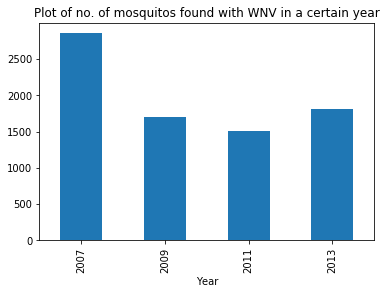

In [50]:
ax = training.groupby(train['Date'].dt.year).count()['WnvPresent'].plot(kind='bar')
ax.set_title('Plot of no. of mosquitos found with WNV in a certain year')
ax.set_xlabel('Year')

- In 2013, even though the amount of locations increased significantly, the number of mosquitos with WNV actually increased compared to 2011.
- In 2007 and 2009, there are no entries for spray data (so it is unsure whether they actually didn't spray in these 2 years or data is missing).

- **As it is unclear whether the spray data is missing or not,**
- **and also there is no evident correlation between spraying, and lower WNV carriers (since in 2013 the amount of sprayed locations was drastically increased, but the number of WNV carriers increased)**
- **the spray data will not be used.**

## 1.4 Combining training set and weather data

In [51]:
training.head()

,Date,Species,Latitude,Longitude,WnvPresent
7577,2011-01-09,CULEX RESTUANS,41.867108,-87.654224,0
6430,2011-06-30,CULEX RESTUANS,41.743402,-87.731435,0
8339,2013-06-21,CULEX RESTUANS,41.682587,-87.707973,0
5316,2009-07-08,CULEX SALINARIUS,41.974689,-87.890615,0
887,2007-01-08,CULEX PIPIENS/RESTUANS,41.986921,-87.689778,0


In [52]:
weather.head()

,Date,Tavg,DewPoint,PrecipTotal
0,2007-01-05,67.5,51.0,0.0
1,2007-01-06,75.5,63.0,0.2
2,2007-01-07,67.0,51.5,0.0
3,2007-01-08,80.5,62.5,0.0
4,2007-01-09,69.5,55.5,0.0


In [53]:
final_training = pd.merge(training, weather, on='Date', how='left')

In [54]:
final_training.head()

,Date,Species,Latitude,Longitude,WnvPresent,Tavg,DewPoint,PrecipTotal
0,2011-01-09,CULEX RESTUANS,41.867108,-87.654224,0,83.0,70.5,0.0000
1,2011-06-30,CULEX RESTUANS,41.743402,-87.731435,0,76.0,61.5,0.0155
2,2013-06-21,CULEX RESTUANS,41.682587,-87.707973,0,76.5,64.0,0.4500
3,2009-07-08,CULEX SALINARIUS,41.974689,-87.890615,0,70.0,59.0,0.2800
4,2007-01-08,CULEX PIPIENS/RESTUANS,41.986921,-87.689778,0,80.5,62.5,0.0000


In [55]:
final_training = pd.get_dummies(data=final_training, columns=['Species'])

In [56]:
features = [col for col in final_training.columns if col != 'WnvPresent']
final_X_training = final_training[features]
final_y_training = final_training['WnvPresent']

In [57]:
final_X_training.drop(columns=['Species_CULEX TERRITANS'], inplace=True)

C:\Users\Pat\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [58]:
final_y_training

0       0
1       0
2       0
3       0
4       0
5       1
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      1
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
7849    0
7850    0
7851    0
7852    0
7853    0
7854    0
7855    0
7856    0
7857    0
7858    0
7859    0
7860    0
7861    0
7862    0
7863    0
7864    0
7865    0
7866    0
7867    0
7868    0
7869    0
7870    0
7871    0
7872    0
7873    0
7874    0
7875    0
7876    0
7877    0
7878    0
Name: WnvPresent, Length: 7879, dtype: int64

In [59]:
final_X_training.to_csv('./data/final_X_training.csv', index=False)
final_y_training.to_csv('./data/final_y_training.csv', index=False)

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [60]:
X_testing = pd.get_dummies(data=X_testing, columns=['Species'])
final_X_testing = pd.merge(X_testing, weather, on='Date', how='left')
final_X_testing.drop(columns=['Species_CULEX TERRITANS'], inplace=True)

In [61]:
final_X_testing.to_csv('./data/final_X_testing.csv', index=False)
y_testing.to_csv('./data/final_y_testing.csv', index=False)

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


# 2. Map Visualization

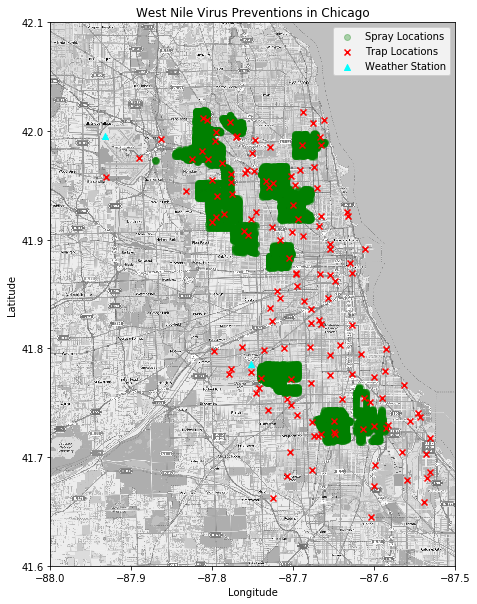

In [62]:
# Load map data
mapdata = np.loadtxt("./data/mapdata_copyright_openstreetmap_contributors.txt")
traps = train[['Latitude', 'Longitude']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# Plot map
plt.figure(figsize=(10,10))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

# Spray locations
sprays = spray[['Longitude', 'Latitude']].drop_duplicates()
sprays = sprays[sprays['Latitude'] < 42.3]  #outliers excluded
plt.scatter(sprays['Longitude'], sprays['Latitude'], marker='o', color='green',alpha=.3, label='Spray Locations')

# Trap locations
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', c='red', label='Trap Locations')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='^', color='cyan', label='Weather Station')
            
plt.title('West Nile Virus Preventions in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png');

Text(0.5, 0, 'Longitude')

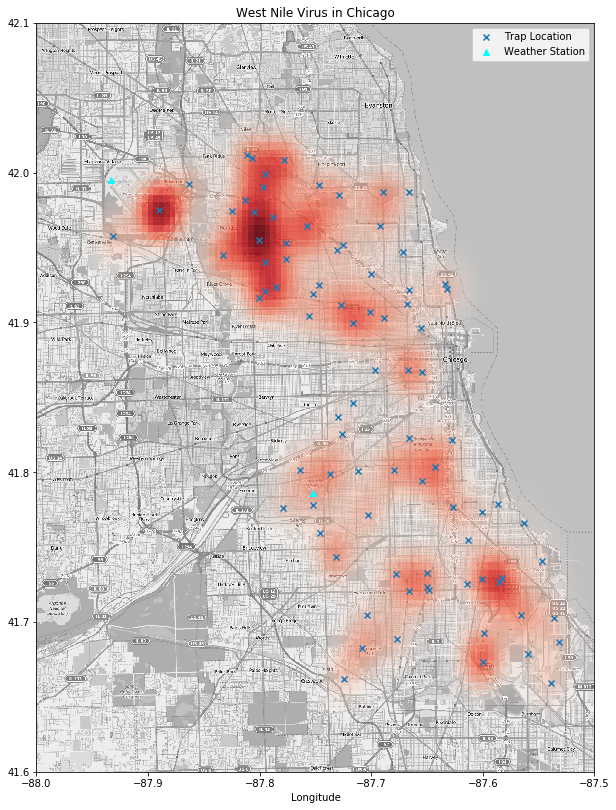

In [74]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
trap_wnv = training[training['WnvPresent'] == 1]
trap_wnv = trap_wnv.groupby(['Date','Longitude', 'Latitude']).sum()['WnvPresent'].reset_index() # Groupby the cols, and sum incidences of WNV
X = trap_wnv[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = trap_wnv[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Location')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='^', color='cyan', label='Weather Station')


plt.title('West Nile Virus in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')

In [78]:
training[training['WnvPresent'] == 1].groupby(['Date','Longitude', 'Latitude']).sum()['WnvPresent'].reset_index()

,Date,Longitude,Latitude,WnvPresent
0,2007-01-08,-87.824812,41.974089,1
1,2007-01-08,-87.800991,41.954690,2
2,2007-01-08,-87.794896,41.940160,1
3,2007-01-08,-87.777921,42.008314,1
4,2007-01-08,-87.752411,41.778297,1
5,2007-01-08,-87.724608,41.662014,1
6,2007-01-08,-87.691810,41.963976,1
7,2007-01-08,-87.677512,41.731922,1
8,2007-01-08,-87.676709,41.688324,1
9,2007-01-08,-87.666901,41.868077,1
